# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
from scipy.stats import norm
from scipy.stats import ttest_ind, ttest_rel, ranksums, wilcoxon
import seaborn as sns

In [3]:
from backend import data_paths
from backend import evaluation_utils
from backend import metrics_utils

# Load Return Period Metrics

In [4]:
_DATASET_RETURN_PERIOD_METRICS_PATH = {
    'google_2014': data_paths.GOOGLE_2014_RETURN_PERIOD_METRICS_DIR,
    'google_1980': data_paths.GOOGLE_1980_RETURN_PERIOD_METRICS_DIR,
    'glofas_2014': data_paths.GLOFAS_2014_RETURN_PERIOD_METRICS_DIR,
    'glofas_1980': data_paths.GLOFAS_1980_RETURN_PERIOD_METRICS_DIR,
}

In [5]:
precisions_by_lead_time = {}
recalls_by_lead_time = {}

precisions_by_return_period = {}
recalls_by_return_period = {}

for dataset, data_path in _DATASET_RETURN_PERIOD_METRICS_PATH.items():
    print(f'Working on {dataset} ...')
    file_path = data_paths.CONCATENATED_RETURN_PERIOD_DICTS_DIR / f'{dataset}_return_period_dicts.pkl'
    with open(file_path, 'rb') as f:
        precisions_by_lead_time[dataset], recalls_by_lead_time[dataset] = pkl.load(f)
    print(f'Finished loading {dataset}. \n')

Working on google_2014 ...
Finished loading google_2014. 

Working on google_1980 ...
Finished loading google_1980. 

Working on glofas_2014 ...
Finished loading glofas_2014. 

Working on glofas_1980 ...
Finished loading glofas_1980. 



# Calculate F1 Scores from Precision & Recall

In [6]:
f1s_by_lead_time = {
    dataset: {
        experiment: {
            lead_time:
              evaluation_utils.f1_from_precision_and_recall_dfs(
                  precision_df=precisions_by_lead_time[dataset][experiment][lead_time],
                  recall_df=recalls_by_lead_time[dataset][experiment][lead_time]
              ) for lead_time in data_paths.LEAD_TIMES
        } for experiment in precisions_by_lead_time[dataset]
    } for dataset in _DATASET_RETURN_PERIOD_METRICS_PATH
}

# Precision & Recall Distributions with Lead Time

In [7]:
# google_dataset = 'google_2014'
# google_experiment = 'kfold_splits'
# glofas_dataset = 'glofas_2014'
# glofas_experiment = metrics_utils.GLOFAS_VARIABLE

# dfs = []
# for rp in evaluation_utils.RETURN_PERIODS[:-2]:
#     dfs = dfs + [
#         f1s_by_lead_time[glofas_dataset][glofas_experiment][0][
#             rp].rename(f'{evaluation_utils.EXPERIMENT_NAMES[glofas_experiment]} ({rp})')
#     ]
#     dfs = dfs + [
#         f1s_by_lead_time[google_dataset][google_experiment][
#             lead_time][rp].rename(f'{lead_time} ({rp})') for lead_time in data_paths.LEAD_TIMES
#     ]
# full_df = pd.concat(dfs, axis=1).dropna()
# full_df

#     rp_columns = [col for col in full_df.columns if f'({return_period})' in col]
#     df = full_df[rp_columns]
#     column_renamer = {col: col.split(f' ({return_period})')[0] for col in df.columns}
#     df.rename(columns=column_renamer, inplace=True)


/tmp/ipykernel_389162/613622937.py:42: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f29d528a050> starts with '_'. It is thus excluded from the legend.
  ax.legend(
/tmp/ipykernel_389162/613622937.py:42: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f29d5123610> starts with '_'. It is thus excluded from the legend.
  ax.legend(
/tmp/ipykernel_389162/613622937.py:42: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f29d513c110> starts with '_'. It is thus excluded from the legend.
  ax.legend(
/tmp/ipykernel_389162/613622937.py:42: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f29d513cb10> starts with '_'. It is thus excluded from the legend.
  ax.legend(
/tmp/ipykernel_389162/613622937.py:42: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f29d513d4d0> starts with '_'. It is thus excluded from the legend.
  ax.legend(
/tmp/ipykernel_389162/613622937.py:59: UserWarning: FixedFormatte

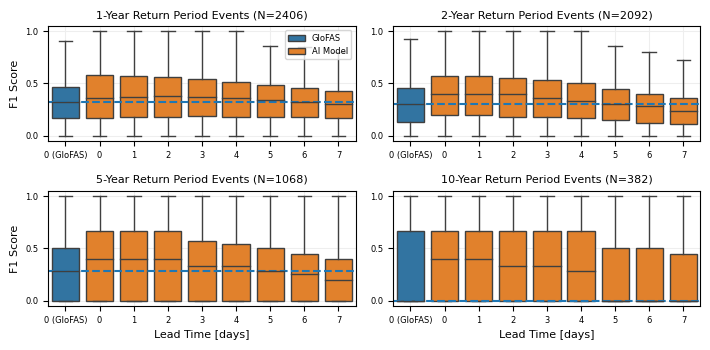

In [8]:
google_dataset = 'google_2014'
google_experiment = 'kfold_splits'
glofas_dataset = 'glofas_2014'
glofas_experiment = metrics_utils.GLOFAS_VARIABLE

fig, axes = plt.subplots(
    2, 2, 
    figsize=(
        evaluation_utils.NATURE_FIG_SIZES['two_column'], 
        evaluation_utils.NATURE_FIG_SIZES['two_column']/2
    )
)

for ax, return_period in zip(axes.flatten(), evaluation_utils.RETURN_PERIODS[:-2]):

    # Plot GloFAS.
    dfs = [
        f1s_by_lead_time[glofas_dataset][glofas_experiment][0][
            return_period].rename(evaluation_utils.EXPERIMENT_NAMES[glofas_experiment])
    ]
    dfs = dfs + [
        f1s_by_lead_time[google_dataset][google_experiment][
            lead_time][return_period].rename(lead_time) for lead_time in data_paths.LEAD_TIMES
    ]
    df = pd.concat(dfs, axis=1).dropna()

    df.rename(columns={evaluation_utils.EXPERIMENT_NAMES[glofas_experiment]: '0 (GloFAS)'}, inplace=True)
    samples = df.shape[0]
    
    boxplot_colors = {'0 (GloFAS)': evaluation_utils.COLORS[0]}
    boxplot_colors.update({lead_time: evaluation_utils.COLORS[1] for lead_time in data_paths.LEAD_TIMES})
    bp = sns.boxplot(
        ax=ax, 
        data=df, 
        showfliers=False, 
        palette=boxplot_colors,
        linewidth=1,
    )
    ax.grid(c='#EEE')
    ax.set_axisbelow(True)
    if ax == axes[0, 0]:
        ax.legend(
            [
                evaluation_utils.EXPERIMENT_NAMES[glofas_experiment]
            ] + ['_']*5 + [evaluation_utils.EXPERIMENT_NAMES[google_experiment],],
            fontsize=evaluation_utils.NATURE_FONT_SIZES['legend'],
            loc='upper right'
        )
    else:
        ax.legend().remove()
    ax.set_title(
        f'{int(return_period)}-Year Return Period Events (N={samples})', 
        fontsize=evaluation_utils.NATURE_FONT_SIZES['title']
    )
    ax.set_xticklabels(
        ax.get_xticklabels(), 
        fontsize=evaluation_utils.NATURE_FONT_SIZES['tick_labels']
    )
    ax.set_yticklabels(
        ax.get_yticklabels(), 
        fontsize=evaluation_utils.NATURE_FONT_SIZES['tick_labels']
    )
    
    if ax in axes[0, :]:
        ax.set_xlabel(None)
    else:
        ax.set_xlabel(
            'Lead Time [days]', 
            fontsize=evaluation_utils.NATURE_FONT_SIZES['axis_label'],
        )
    if ax in axes[:, 0]:
        ax.set_ylabel(
            'F1 Score', 
            fontsize=evaluation_utils.NATURE_FONT_SIZES['axis_label'],
        )

    ax.plot(
        [-0.5, 8.5],
        [df['0 (GloFAS)'].median()]*2,
        c=evaluation_utils.COLORS[0],
        ls='--'
    )

plt.tight_layout()

evaluation_utils.save_figure(data_paths.LEAD_TIME_RELIABILITY_DISTRIBUTIONS_FILENAME)

# Statistical Significance of Differences with GloFAS

In [9]:
google_dataset = 'google_2014'
google_experiment = 'kfold_splits'
glofas_dataset = 'glofas_2014'
glofas_experiment = metrics_utils.GLOFAS_VARIABLE

for return_period in [1.01, 2, 5, 10]:
    for lead_time in data_paths.LEAD_TIMES:
        df = pd.concat(
            [
                f1s_by_lead_time[glofas_dataset][glofas_experiment][0][return_period].rename(evaluation_utils.EXPERIMENT_NAMES[glofas_experiment]).rename('glofas'),
                f1s_by_lead_time[google_dataset][google_experiment][lead_time][return_period].rename(lead_time)
            ], 
        axis=1
        ).dropna()
        
        print(f'--- {return_period = } --- {lead_time = } ------------------------------------')
        print('Mean Difference:', (df['glofas'] - df[lead_time]).mean())
        stats = wilcoxon(df['glofas'], df[lead_time])
        cohen_d = evaluation_utils.cohen_d(df[lead_time].values, df['glofas'].values)
        zstatistic = norm.isf(stats.pvalue / 2)
        n = df.shape[0]
        effect_size = zstatistic / n**(1/2)
        print(stats, effect_size, cohen_d, n)
        print('---------------------------------------------------------------------\n')

--- return_period = 1.01 --- lead_time = 0 ------------------------------------
Mean Difference: -0.05458886032380632
WilcoxonResult(statistic=837844.0, pvalue=1.0890639929869122e-57) 0.32612291321941966 0.2535908920268161 2410
---------------------------------------------------------------------

--- return_period = 1.01 --- lead_time = 1 ------------------------------------
Mean Difference: -0.057227539559852304
WilcoxonResult(statistic=814350.5, pvalue=3.222682414841535e-63) 0.3418093463765351 0.2687925253689626 2411
---------------------------------------------------------------------

--- return_period = 1.01 --- lead_time = 2 ------------------------------------
Mean Difference: -0.056817473079750776
WilcoxonResult(statistic=820026.0, pvalue=3.1540788960620277e-63) 0.3416228898798914 0.2708970688099132 2414
---------------------------------------------------------------------

--- return_period = 1.01 --- lead_time = 3 ------------------------------------
Mean Difference: -0.0456